In [1]:
# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
import folium
import pickle
import random

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score,recall_score, f1_score, confusion_matrix

from src import load_data as ld
from src import utils
from src import feature_exploring as fexp
from src import map_plot as mp
from src import ml_utils as mlu

import warnings
warnings.filterwarnings("ignore")


In [12]:
#### loading and preparing the new data
'''
The script is using the validation data to predict and show plots. This data is unseen to the model.
'''

# loading the pickeled model
pickled_model = pickle.load(open('results/grid_search_best_rf.pkl', 'rb'))

# loading the new data
new_data = pd.read_csv('data/validation_by_mmsi.csv')
# new_data = new_data_load.sample(10000)

# droping all the nul values (in the future, predict them)
new_data_na = new_data.dropna()

# setting a threshold to is_fishing
new_data_na['is_fishing'] = mlu.set_threshold(new_data_na,0.5)

# save mmsi col
mmsi_col = new_data_na['mmsi']

# columns to keep for the prediction
cols = fexp.column_select(new_data_na,drop_always=True,drop_mmsi=True,drop_y=True,drop_gear=True,col_groups=['1800','10800','21600','43200','86400'])
new_data_cols = new_data_na[cols]

# scaling the train data and using the same object to scale the test data
new_data_cols['distance_from_port'] = utils.min_max(new_data_cols,'distance_from_port')
new_data_cols['distance_from_shore'] = utils.min_max(new_data_cols,'distance_from_shore')


In [13]:
#### the prediction

prediction = pickled_model.predict(new_data_cols)

In [42]:
feature_importances = {k:v*100 for k,v in zip(new_data_cols.columns,pickled_model.feature_importances_)}
feature_importances_sorted = [(i   ,feature_importances[i]) for i in sorted(feature_importances,key=feature_importances.get, reverse=True)]
feature_importances_sorted

[('measure_pos_1800', 10.005638639261363),
 ('distance_from_shore', 8.627865918851649),
 ('measure_speedstddev_43200_log', 7.63397256734881),
 ('measure_speedavg_10800', 6.27058448116501),
 ('Unnamed: 0', 6.107544718485347),
 ('measure_speed', 5.503297115139031),
 ('measure_speedstddev_43200', 5.319246069983211),
 ('measure_speedstddev_86400_log', 4.12796719352934),
 ('measure_pos_86400', 3.999650944617889),
 ('measure_speedavg_21600', 3.6894019106135536),
 ('measure_speedavg_43200', 3.586063259705913),
 ('measure_speedstddev_86400', 3.2556430218762693),
 ('distance_from_port', 2.966504104855619),
 ('measure_speedstddev_21600', 2.7522045658740715),
 ('measure_pos_43200', 2.5060576926907006),
 ('measure_speedstddev_21600_log', 2.464875609074274),
 ('measure_coursestddev_86400_log', 1.6858514855745732),
 ('measure_coursestddev_43200', 1.5778120221267784),
 ('measure_coursestddev_43200_log', 1.5502224528490323),
 ('measure_speedavg_86400', 1.1461428369456934),
 ('measure_pos_21600', 1.029

In [5]:
#### the results

result = pd.DataFrame({'mmsi':mmsi_col,
                       'is_fishing':new_data_na['is_fishing'],
                       'prediction':prediction,
                       'lat':new_data_na['lat'],
                       'lon':new_data_na['lon'],
                       'gear_type':new_data_na['gear_type']
                      })

y_test = list(result['is_fishing'])
y_pred_test = list(result['prediction'])

scores = {'Accuracy': accuracy_score(y_test, y_pred_test),
           'Recall': recall_score(y_test, y_pred_test),
           'F1': f1_score(y_test, y_pred_test),
           'set': 'test'}

In [26]:
# save the predictions of every single vessel on a list
vessel_results = []
vessels = result['mmsi'].unique()
for i in vessels:
    vessel_results.append({
        'mmsi':i,
        'Accuracy': f1_score(result[result['mmsi']==i]['is_fishing'], result[result['mmsi']==i]['prediction'],zero_division=0),
        'Recall': recall_score(result[result['mmsi']==i]['is_fishing'], result[result['mmsi']==i]['prediction'],zero_division=0),
        'F1': f1_score(result[result['mmsi']==i]['is_fishing'], result[result['mmsi']==i]['prediction'],zero_division=0),
        'gear_type': result[result['mmsi']==i]['gear_type'].unique()[0]
                          })

In [ ]:
# saving plots of all vessels 
for i in result.mmsi.unique():
    
    latitudes = np.array(result[result.mmsi==i]['lat'])
    longitudes = np.array(result[result.mmsi==i]['lon'])
    coords = [(lat,lon) for lat,lon in zip(latitudes,longitudes)]
    
    m_real = mp.folium_markers_real(result,i)
    m_pred = mp.folium_markers_pred(result,i)
    
    m_real.save(f'results/plots/{i}_real.html')
    m_pred.save(f'results/plots/{i}_pred.html')
    
# save the results in a txt
output_file = 'results/results_by_vessel.txt'

with open(output_file,'w') as f:
    for i in vessel_results:
        f.write(f'{i}'+'\n')


In [32]:
coords = [(lat,lon) for lat, lon in zip(np.array(un_mmsi['lat']),np.array(un_mmsi['lon']))]
coords

[(-4.625565052, 55.4626083374),
 (-4.625565052, 55.4626083374),
 (-4.6256232262, 55.4625854492),
 (-4.6256232262, 55.4625854492),
 (-4.6255583763, 55.4625892639),
 (-4.6255583763, 55.4625892639),
 (-4.6256165504, 55.4626350403),
 (-4.6256165504, 55.4626350403),
 (-4.6256399155, 55.4626083374),
 (-4.6256399155, 55.4626083374),
 (-4.6255750656, 55.4626197815),
 (-4.6255750656, 55.4626197815),
 (-4.6255850792, 55.4626083374),
 (-4.6255850792, 55.4626083374),
 (-4.6255617142, 55.4625892639),
 (-4.6255617142, 55.4625892639),
 (-4.6256017685, 55.4626197815),
 (-4.6256017685, 55.4626197815),
 (-4.6255898476, 55.4626121521),
 (-4.6255898476, 55.4626121521),
 (-4.6255784035, 55.4626274109),
 (-4.6255784035, 55.4626274109),
 (-4.6255731583, 55.4626350403),
 (-4.6255731583, 55.4626350403),
 (-4.6255550385, 55.4625816345),
 (-4.6255550385, 55.4625816345),
 (-4.6255598068, 55.4625740051),
 (-4.6255598068, 55.4625740051),
 (-4.6256051064, 55.4626121521),
 (-4.6256051064, 55.4626121521),
 (-4.6255364

In [64]:
mp.folium_markers_polyline(coords)

In [10]:
df_all_gears

,measure_coursestddev_43200,measure_speedavg_86400,measure_coursestddev_1800_log,measure_coursestddev_10800_log,measure_courseavg_43200,measure_cos_course,measure_daylightavg_1800,measure_coursestddev_21600,measure_speedstddev_1800,measure_distance_from_port,...,measure_coursestddev_1800,measure_pos_21600,measure_coursestddev_3600_log,measure_speedavg_1800,measure_lonavg_43200,measure_speedstddev_1800_log,measure_courseavg_21600,measure_coursestddev_10800,measure_speed,gear_type
0,0.405208,0.795068,-3.000000,-0.726021,0.476011,0.570607,0.0,0.270995,8.171219e-07,1.0,...,0.000000e+00,0.014033,-3.000000,0.817647,178.656452,-2.999645,0.448175,0.186923,0.817647,Drifting_longlines
1,0.407976,0.795294,-3.000000,-0.699922,0.466625,0.570607,0.0,0.277235,5.777924e-07,1.0,...,0.000000e+00,0.015865,-3.000000,0.817647,178.656779,-2.999749,0.438519,0.198562,0.817647,Drifting_longlines
2,0.410486,0.787811,-3.000000,-2.205099,0.457757,0.563977,0.0,0.206975,8.295946e-07,1.0,...,0.000000e+00,0.021051,-3.000000,0.841176,178.658829,-2.999640,0.408849,0.005236,0.841176,Drifting_longlines
3,0.412517,0.788355,-3.000000,-2.183525,0.449312,0.563977,0.0,0.214575,5.866593e-07,1.0,...,0.000000e+00,0.026102,-3.000000,0.841176,178.660783,-2.999745,0.400355,0.005554,0.841176,Drifting_longlines
4,0.434009,0.784396,-2.999726,-0.559868,0.444981,-0.057939,0.0,0.264756,8.264437e-07,1.0,...,6.311997e-07,0.031004,-0.491916,0.835294,178.663232,-2.999641,0.396644,0.274506,0.835294,Drifting_longlines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531363,0.688557,0.737977,-0.896795,-0.446202,0.548879,0.443076,1.0,0.588671,8.823528e-03,1.0,...,1.258251e-01,0.049442,-0.943063,0.820588,-7.040801,-2.007733,0.635056,0.356930,0.829412,Trawlers
1531364,0.690718,0.734565,-0.603594,-0.447973,0.545015,-0.060399,0.0,0.541935,1.663781e-01,1.0,...,2.481185e-01,0.050175,-0.768937,0.711765,-7.045661,-0.776301,0.669052,0.355473,0.476471,Trawlers
1531365,0.688723,0.732301,-0.578117,-0.450140,0.548433,-0.060399,0.0,0.537981,1.764706e-01,1.0,...,2.631694e-01,0.051045,-0.723635,0.652941,-7.048614,-0.750874,0.671296,0.353699,0.476471,Trawlers
1531366,0.689558,0.727663,-2.999914,-0.828845,0.547000,-0.066545,0.0,0.461183,0.000000e+00,1.0,...,1.979668e-07,0.053327,-0.585367,0.464706,-7.054854,-3.000000,0.704406,0.147305,0.464706,Trawlers


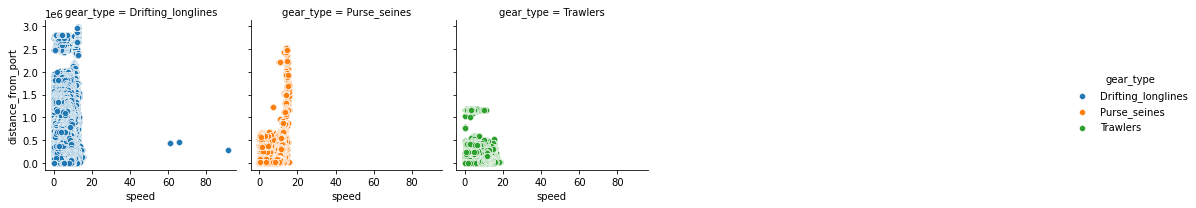

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv('data/validation_by_mmsi.csv')

grid = sns.FacetGrid(df, col = "gear_type", hue = "gear_type", col_wrap=5)
grid.map(sns.scatterplot, "speed", "distance_from_port")
grid.add_legend()

plt.show()

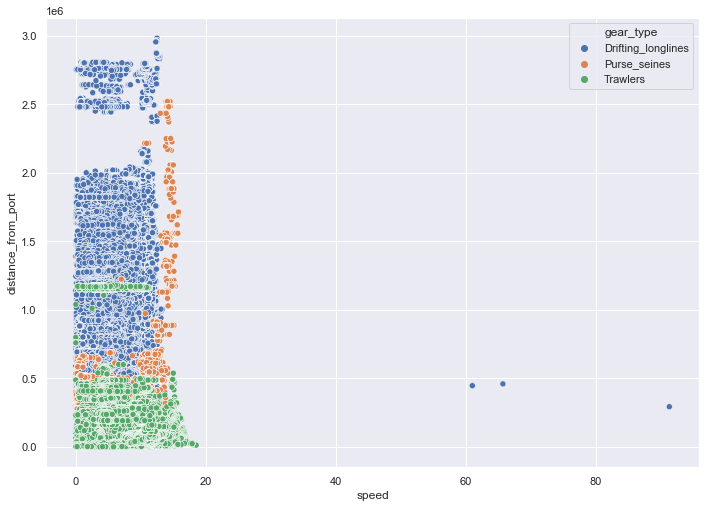

In [13]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = df, x = "speed", y = "distance_from_port", hue = "gear_type")
plt.savefig('no_linearity.png')
plt.show()


---------------------------------------------------------------------

In [14]:
df_all_gears

,measure_coursestddev_43200,measure_speedavg_86400,measure_coursestddev_1800_log,measure_coursestddev_10800_log,measure_courseavg_43200,measure_cos_course,measure_daylightavg_1800,measure_coursestddev_21600,measure_speedstddev_1800,measure_distance_from_port,...,measure_coursestddev_1800,measure_pos_21600,measure_coursestddev_3600_log,measure_speedavg_1800,measure_lonavg_43200,measure_speedstddev_1800_log,measure_courseavg_21600,measure_coursestddev_10800,measure_speed,gear_type
0,0.405208,0.795068,-3.000000,-0.726021,0.476011,0.570607,0.0,0.270995,8.171219e-07,1.0,...,0.000000e+00,0.014033,-3.000000,0.817647,178.656452,-2.999645,0.448175,0.186923,0.817647,Drifting_longlines
1,0.407976,0.795294,-3.000000,-0.699922,0.466625,0.570607,0.0,0.277235,5.777924e-07,1.0,...,0.000000e+00,0.015865,-3.000000,0.817647,178.656779,-2.999749,0.438519,0.198562,0.817647,Drifting_longlines
2,0.410486,0.787811,-3.000000,-2.205099,0.457757,0.563977,0.0,0.206975,8.295946e-07,1.0,...,0.000000e+00,0.021051,-3.000000,0.841176,178.658829,-2.999640,0.408849,0.005236,0.841176,Drifting_longlines
3,0.412517,0.788355,-3.000000,-2.183525,0.449312,0.563977,0.0,0.214575,5.866593e-07,1.0,...,0.000000e+00,0.026102,-3.000000,0.841176,178.660783,-2.999745,0.400355,0.005554,0.841176,Drifting_longlines
4,0.434009,0.784396,-2.999726,-0.559868,0.444981,-0.057939,0.0,0.264756,8.264437e-07,1.0,...,6.311997e-07,0.031004,-0.491916,0.835294,178.663232,-2.999641,0.396644,0.274506,0.835294,Drifting_longlines
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531363,0.688557,0.737977,-0.896795,-0.446202,0.548879,0.443076,1.0,0.588671,8.823528e-03,1.0,...,1.258251e-01,0.049442,-0.943063,0.820588,-7.040801,-2.007733,0.635056,0.356930,0.829412,Trawlers
1531364,0.690718,0.734565,-0.603594,-0.447973,0.545015,-0.060399,0.0,0.541935,1.663781e-01,1.0,...,2.481185e-01,0.050175,-0.768937,0.711765,-7.045661,-0.776301,0.669052,0.355473,0.476471,Trawlers
1531365,0.688723,0.732301,-0.578117,-0.450140,0.548433,-0.060399,0.0,0.537981,1.764706e-01,1.0,...,2.631694e-01,0.051045,-0.723635,0.652941,-7.048614,-0.750874,0.671296,0.353699,0.476471,Trawlers
1531366,0.689558,0.727663,-2.999914,-0.828845,0.547000,-0.066545,0.0,0.461183,0.000000e+00,1.0,...,1.979668e-07,0.053327,-0.585367,0.464706,-7.054854,-3.000000,0.704406,0.147305,0.464706,Trawlers


In [16]:
def set_threshold(df,threshold):
    '''
    feature that set a threshold and applies it to the is_fishing column
    
    :param df: columns you want to min max
    :type df: dataframe
    
    :param threshold: a number [0,1], i.e: threshold==0.6, all values bigger than 0.6 will be set on 1
    :type threshold: float
    
    :return: the column with only 0 and 1 values
    '''
    threshold_col = np.where(df.is_fishing > threshold,1,0)
    
    return threshold_col

In [18]:
df_all_gears['is_fishing'] = set_threshold(df_all_gears,0.5)

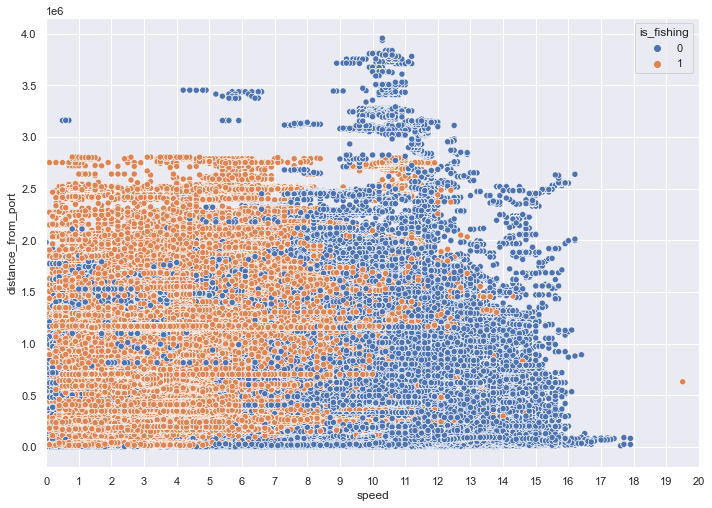

In [20]:
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data = df_all_gears,ax=ax, x = "speed", y = "distance_from_port", hue = "is_fishing")
# plt.savefig('no_linearity.png')
ax.set_xlim(0,20)
ax.set_xticks(range(0,21))
plt.show()
